<a href="https://colab.research.google.com/github/DarkyWarky/Sms_spam-Classifier/blob/main/spam-classifier-performance-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
!pip install nltk scikit-learn matplotlib


In [93]:
import pandas as pd
import requests
from zipfile import ZipFile
from io import BytesIO
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import re


In [94]:
nltk.download('stopwords')
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
response = requests.get(url)
with ZipFile(BytesIO(response.content)) as z:
    with z.open('SMSSpamCollection') as f:
        df = pd.read_csv(f, sep='\t', names=['label', 'message'])

df.info()

df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


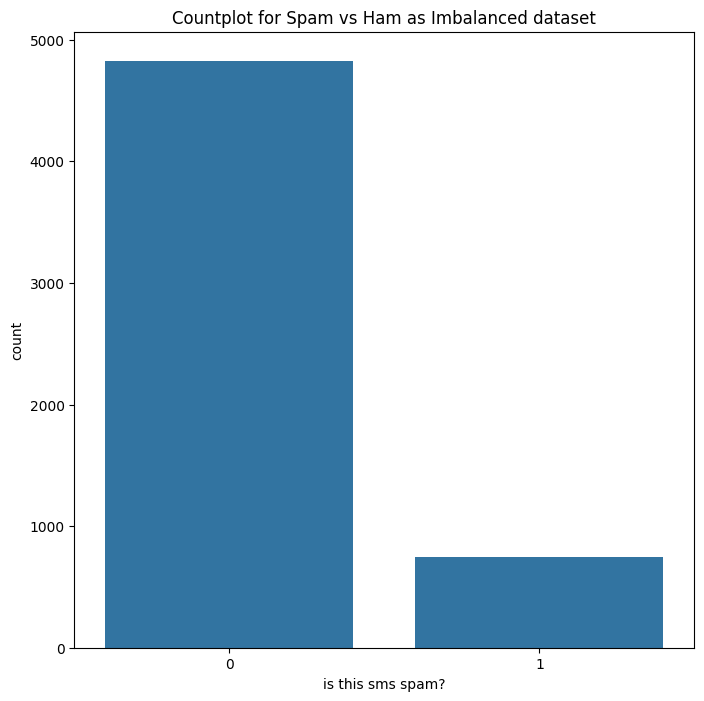

In [95]:

plt.figure(figsize=(8,8))
g = sns.countplot(x="label",data=df)
p = plt.title("Countplot for Spam vs Ham as Imbalanced dataset")
p=plt.xlabel("is this sms spam?")
p = plt.ylabel("count")


In [96]:
only_spam = df[df["label"]==1]
only_spam

,label,message
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
5,1,FreeMsg Hey there darling it's been 3 week's n...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...
11,1,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [97]:
print("no. of spam :",len(only_spam))
print("no. of ham :",len(df)-len(only_spam))


no. of spam : 747
no. of ham : 4825


In [98]:
count = int((df.shape[0]-only_spam.shape[0])/only_spam.shape[0] )
count

6

In [99]:
for i in range(0,count-1):
  df= pd.concat([df,only_spam])
df.shape

(9307, 2)

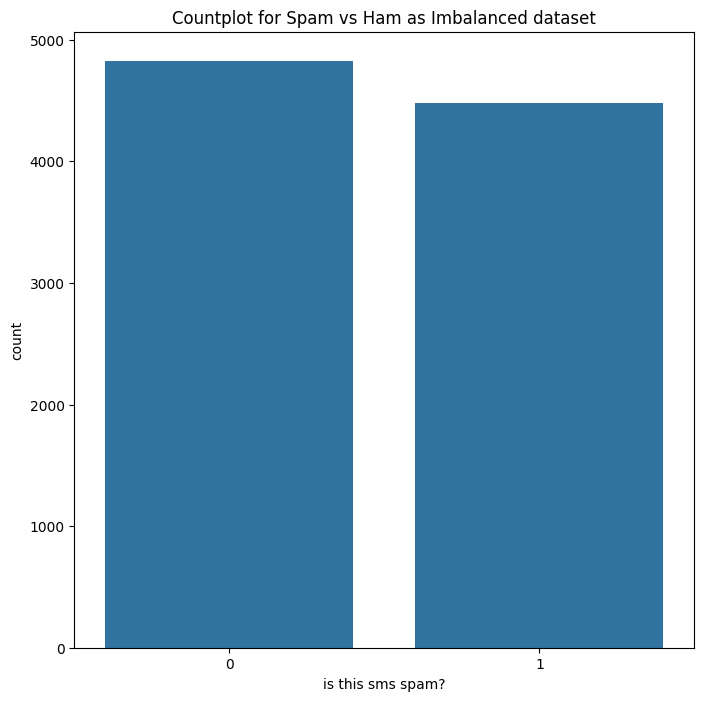

In [100]:
plt.figure(figsize=(8,8))
g = sns.countplot(x="label",data=df)
p = plt.title("Countplot for Spam vs Ham as Imbalanced dataset")
p=plt.xlabel("is this sms spam?")
p = plt.ylabel("count")

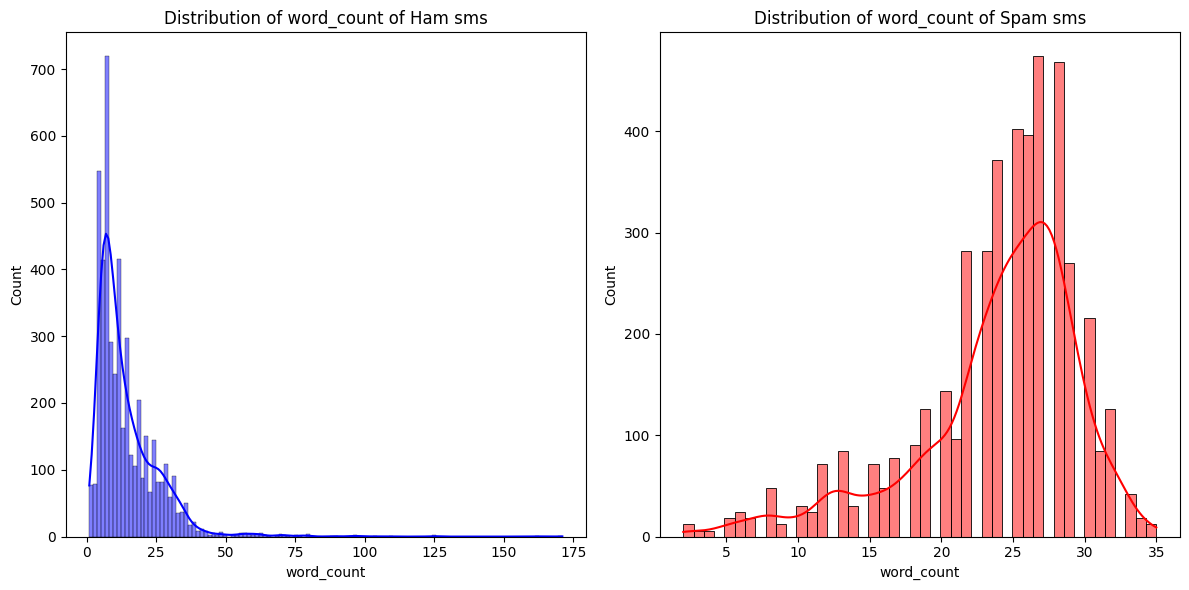

In [101]:
df['word_count']= df['message'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))

# Plot for Ham sms
plt.subplot(1, 2, 1)
g = sns.histplot(df[df["label"] == 0].word_count, kde=True, color='blue')  # Adjusted color for clarity
plt.title("Distribution of word_count of Ham sms")

# Plot for Spam sms
plt.subplot(1, 2, 2)
g = sns.histplot(df[df["label"] == 1].word_count, kde=True, color='red')
plt.title("Distribution of word_count of Spam sms")

plt.tight_layout()
plt.show()

In [102]:
def currency(data):
  currency_symbol =['$','€','£','¥','₹']
  for i in currency_symbol:
    if i in df:
      return 1
    return 0

In [122]:
df['contains_currency_symbols']=df['message'].apply(currency)
df

,label,message,word_count,contains_currency_symbols,contains_number
0,0,"Go until jurong point, crazy.. Available only ...",20,0,0
1,0,Ok lar... Joking wif u oni...,6,0,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28,0,1
3,0,U dun say so early hor... U c already then say...,11,0,0
4,0,"Nah I don't think he goes to usf, he lives aro...",13,0,0
...,...,...,...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...,16,0,1
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,33,0,1
5547,1,Had your contract mobile 11 Mnths? Latest Moto...,28,0,1
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...,28,0,1


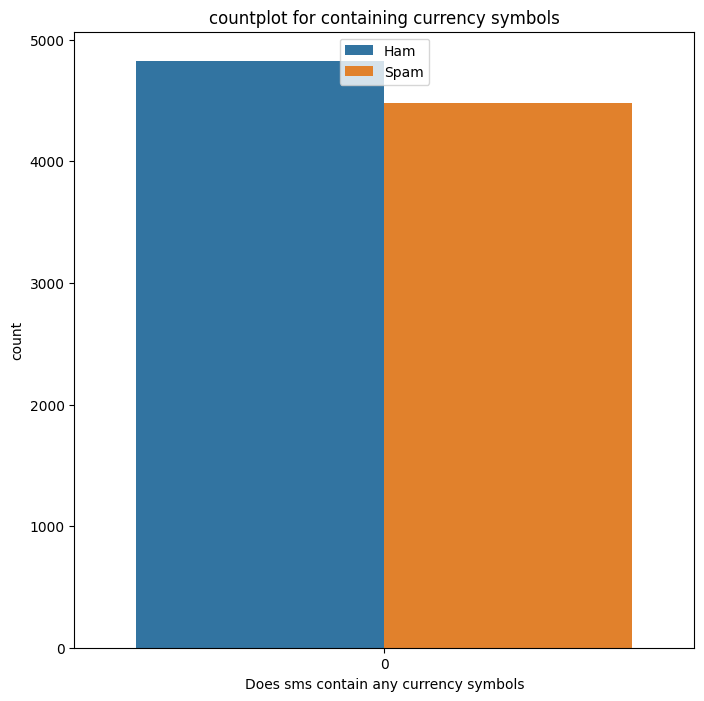

In [104]:
plt.figure(figsize=(8,8))
g= sns.countplot(x='contains_currency_symbols',data=df,hue='label')
p=plt.title("countplot for containing currency symbols")
p=plt.xlabel("Does sms contain any currency symbols")
p=plt.ylabel("count")
p=plt.legend(labels=['Ham','Spam'],loc=9)

In [105]:
def number(data):
  for i in data:
    if ord(i)>=48 and ord(i)<=57:
      return 1
  return 0

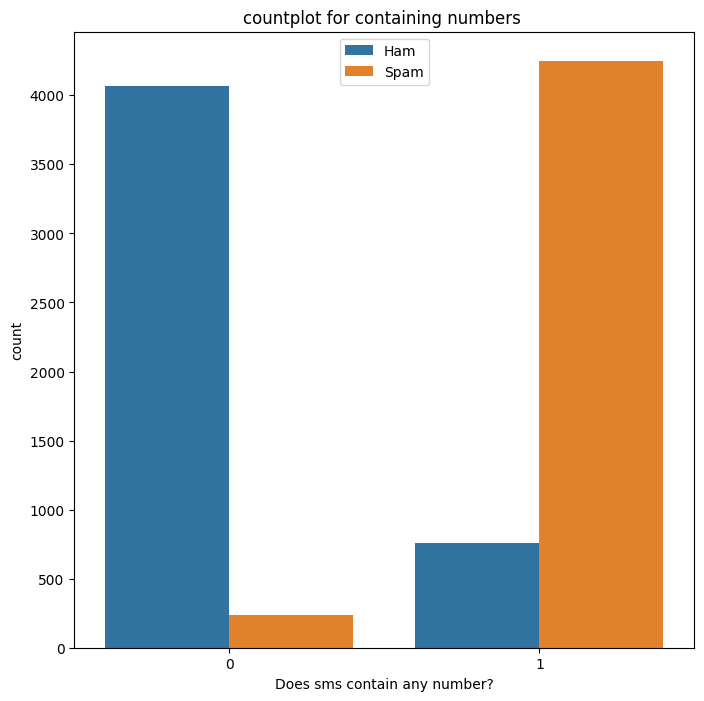

In [106]:
df["contains_number"]=df['message'].apply(number)
plt.figure(figsize=(8,8))
g= sns.countplot(x='contains_number',data=df,hue='label')
p=plt.title("countplot for containing numbers ")
p=plt.xlabel("Does sms contain any number?")
p=plt.ylabel("count")
p=plt.legend(labels=['Ham','Spam'],loc=9)

In [107]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [108]:
stop_words = set(stopwords.words('english'))

corpus =[]
ps = PorterStemmer()
wnl= WordNetLemmatizer()
for sms in list(df.message):
  message = re.sub(pattern='[^a-zA-Z]', repl='',string=sms)
  message= message.lower()
  message = message.split()
  filtered_message = [word for word in message if word not in set(stopwords.words('english'))]
  lemm_words = [wnl.lemmatize(word) for word in message]
  message =''.join(lemm_words)
  corpus.append(message)
# df['message'] = df['message'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() if word.lower() not in stop_words]))


In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = 500)
vectors = tfidf.fit_transform(corpus).toarray()
feature_names = tfidf.get_feature_names_out()

In [110]:
X= pd.DataFrame(vectors,columns=feature_names)
y= df['label']

In [111]:
from sklearn.model_selection import cross_val_score

In [112]:
# X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# vectorizer = CountVectorizer()
# X_train_vectorized = vectorizer.fit_transform(X_train)
# X_test_vectorized = vectorizer.transform(X_test)

model = MultinomialNB()
# model.fit(X_train_vectorized, y_train)
cv = cross_val_score(model,X,y,scoring='f1',cv=10)
print(round(cv.mean(),3))
print(round(cv.std(),3))
# y_pred = model.predict(X_test_vectorized)

# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}\n')

# print('Classification Report:')
# print(classification_report(y_test, y_pred))

# print('Confusion Matrix:')
# print(confusion_matrix(y_test, y_pred))

0.556
0.007


In [113]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77       959
           1       1.00      0.37      0.54       903

    accuracy                           0.69      1862
   macro avg       0.81      0.68      0.66      1862
weighted avg       0.81      0.69      0.66      1862

[[959   0]
 [569 334]]


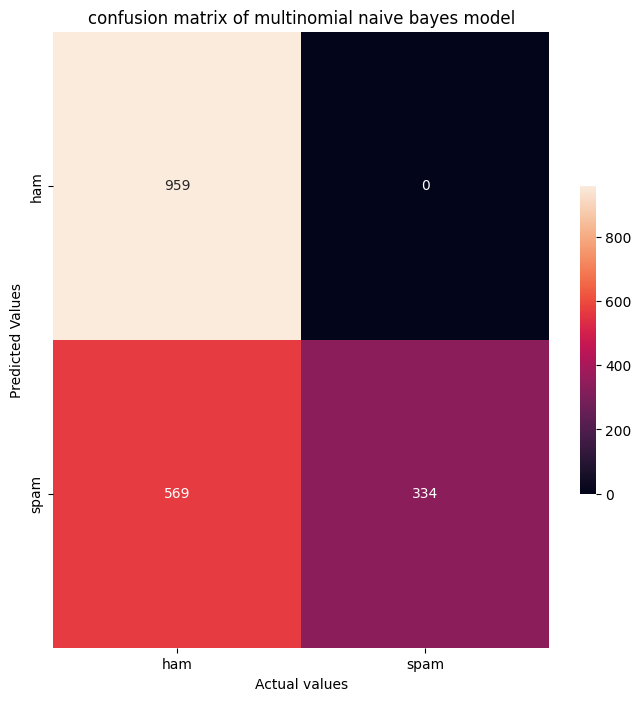

In [114]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize =(8,8))
axis_labels = ['ham','spam']
g = sns.heatmap(data=cm,xticklabels =axis_labels,yticklabels=axis_labels,annot=True,fmt = 'g',cbar_kws={'shrink':0.5})
p=plt.title("confusion matrix of multinomial naive bayes model")
p = plt.xlabel("Actual values")
p = plt.ylabel("Predicted Values")

In [115]:
# fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_vectorized)[:, 1])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')

# plt.show()


In [116]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
cv = cross_val_score(dt,X,y,scoring='f1',cv=10)
print(round(cv.mean(),3))
print(round(cv.std(),3))

0.937
0.004


In [117]:
dt.fit(X_train,y_train)
y_pred1= dt.predict(X_test)
print(classification_report(y_test,y_pred1))
print(confusion_matrix(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       959
           1       1.00      0.88      0.93       903

    accuracy                           0.94      1862
   macro avg       0.95      0.94      0.94      1862
weighted avg       0.95      0.94      0.94      1862

[[959   0]
 [111 792]]


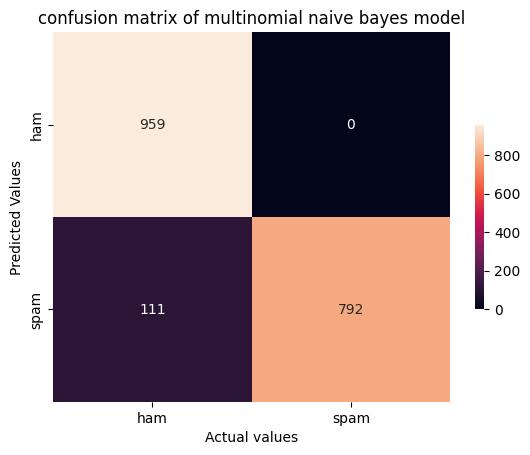

In [118]:
cm = confusion_matrix(y_test, y_pred1)
axis_labels = ['ham','spam']
g = sns.heatmap(data=cm,xticklabels =axis_labels,yticklabels=axis_labels,annot=True,fmt = 'g',cbar_kws={'shrink':0.5})
p=plt.title("confusion matrix of multinomial naive bayes model")
p = plt.xlabel("Actual values")
p = plt.ylabel("Predicted Values")

In [119]:
def predict_spam(sms):
  message = re.sub(pattern='[^a-zA-Z]', repl='',string=sms)
  message= message.lower()
  message = message.split()
  filtered_message = [word for word in message if word not in set(stopwords.words('english'))]
  lemm_words = [wnl.lemmatize(word) for word in filtered_message]
  message =' '.join(lemm_words)
  temp = tfidf.transform([message]).toarray()
  return dt.predict(temp)


In [123]:
sample = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

if predict_spam(sample):
  print("This is spam message")
else:
  print("This is ham message")


This is spam message


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
